# Physics Informed Neural Networks
Preamble: Run the cells below for the necessary package imports. Setting up a python virtual environment is recommended. For a part of this notebook you will need Julia installed on your machine. If you are running this on Google Colab then running the cells as are will work.

In this notebook we want to give you a brief overview of what PINNs are and walk you through a library, `neurodiffeq`, to show how they can be used to solve physics problems.

In [1]:
#NeuroDiffEq can be used without running this cell. This is for loading Julia and installing/importing PySR for an example at the end.
try:
    import pysr

except ImportError:
    import subprocess
    import sys

    print("Installing Julia and PySR. This might take some time...")

    shell_script = '''
    # @title Install Julia and PySR (Takes some time)
    %%shell
    set -e

    #---------------------------------------------------#
    JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
    JULIA_PACKAGES="IJulia BenchmarkTools"
    JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
    JULIA_NUM_THREADS=2
    #---------------------------------------------------#

    if [ -z `which julia` ]; then
        # Install Julia
        JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
        echo "Installing Julia $JULIA_VERSION..."
        BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
        URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
        wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
        tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
        rm /tmp/julia.tar.gz

        # Install Packages
        nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
        if [ $GPU -eq 1 ]; then
        JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
        fi
        for PKG in `echo $JULIA_PACKAGES`; do
        echo "Installing Julia package $PKG..."
        julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
        done

        # Install kernel and rename it to "julia"
        echo "Installing IJulia kernel..."
        julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
            "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
        KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
        KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
        mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

        echo ''
        echo "Successfully installed `julia -v`!"
    fi
    '''

    process = subprocess.Popen(shell_script, shell=True, executable='/bin/bash')
    process.wait()

    subprocess.run([sys.executable, '-m', 'pip', 'install', '-U', 'pysr'])
    subprocess.run([sys.executable, '-m', 'pysr', 'install'])


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [1]:
try:
    import neurodiffeq
except:
    import os
    os.system("pip install neurodiffeq")

c:\Users\nachi\OneDrive\Desktop\cphysics\c_physics_projects\.pysrenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from neurodiffeq.neurodiffeq import safe_diff as diff
from neurodiffeq.ode import solve, solve_system
from neurodiffeq.solvers import Solver1D 
from neurodiffeq.monitors import Monitor1D #Helps visualize the loss and fit at certain epochs
from neurodiffeq.conditions import IVP

import matplotlib
import matplotlib.pyplot as plt
from neurodiffeq.callbacks import ActionCallback
from neurodiffeq.networks import FCNN # fully-connect neural network
import torch.nn as nn                 # PyTorch neural network module
from neurodiffeq.generators import Generator1D
from neurodiffeq.conditions import NoCondition, IVP
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.pde import make_animation
from neurodiffeq.solvers import Solver2D
from neurodiffeq.monitors import Monitor2D
from neurodiffeq.generators import Generator2D
from mpl_toolkits.mplot3d  import Axes3D

import copy

%matplotlib inline

## What is a neural network?

Mimics the neurons in our own brains!
Consists of an input node, layers of hidden nodes (a "black box") and the output node

A given node is connected to several nodes in the layer above and below it. 
!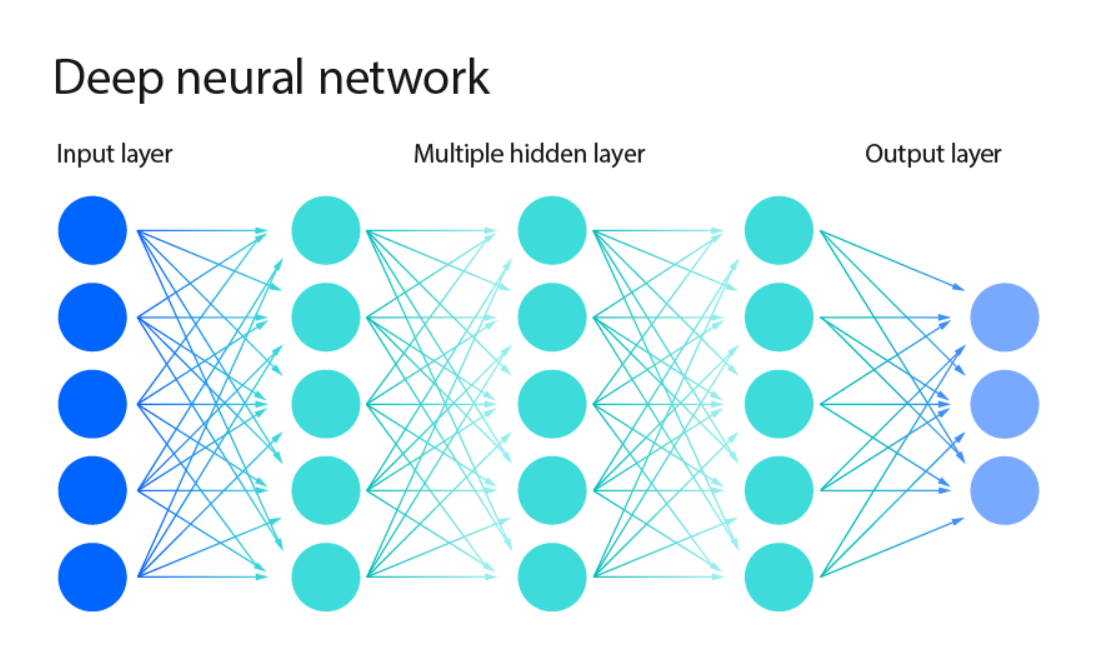

A node receives a different input across each connection, which is then multiplied by a 'weight,' a coefficient specific to each connection. All the products are added into a single number--if this exceeds a certain threshold, the neuron fires--sending the value as an output.

Most neural networks are feed-forward, meaning that information can only flow from the input to the output. 

Initially, all the weights are randomly assigned. Through training, the weights are adjusted so that relevant connections are strengthened and irrelevant ones are removed. Many are trained using an algorithm called backpropagation.

This involves a few steps:
* Forward Pass (using the training function)
* Loss function (measures the difference between the expected and actual output) <br><i>Different models have better suited loss functions (i.e., regression models and mean squared error)</i>
* Backward Pass <br> <i> Since a neural network is basically a stack of nested functions, you can use the loss function to chain rule your way through the layers. This results in a gradient (vector of derivative for each weight)</i>
* Gradient Descent (use the calculated gradient to adjust and readjust the weights of the model)

Overall, the goal of the training process is to <b>minimize</b> the loss function. 

# What makes PINNs different?

##### Physics Informed Neural Networks enforce physical laws or constraints unto traditional neural networks. 

+ Typical Neural Networks take inputs and produce outputs, PINNs add constraints to these outputs in a loss function.

+ Example - Fluid Flow: Take position and time as inputs and output velocity components and pressure [gradients]. Take derivaties (Automatic Differentiation) of velocity field and pressure in accoradance to equations of fluid flow to ensure network is physical (Add terms to loss function that depend on conservation laws/PDE behavior)

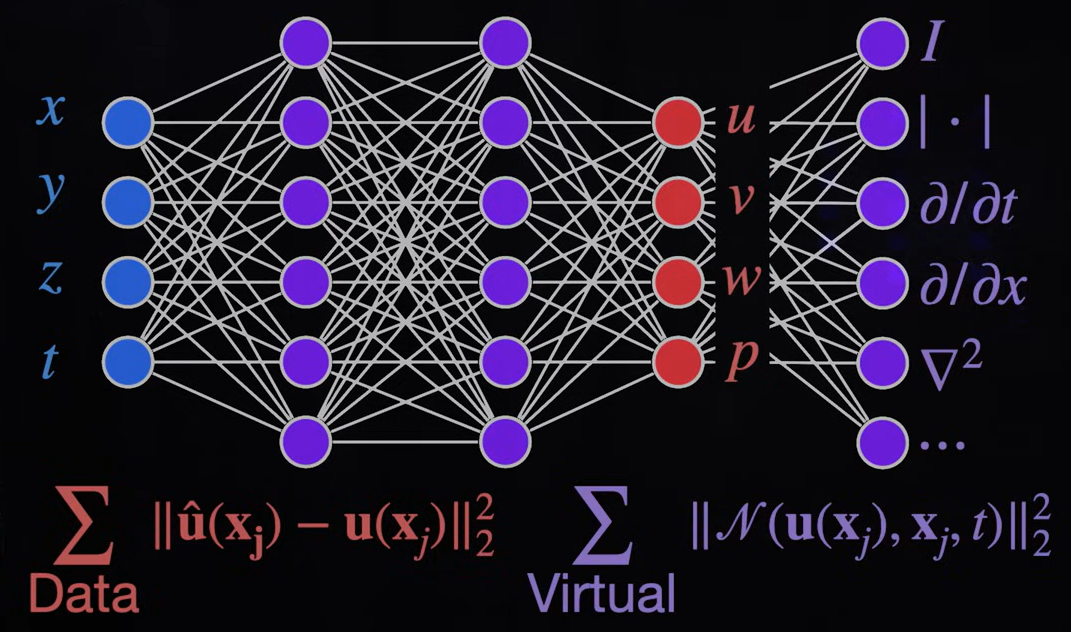

+ PINNs can allow for work to be conducted with relatively small data sets. Even if you don't have data from actual measurements, you can still evaluate if your data is physical on "virtual points"

+ Note - Actual error between predicted points and experimental terms can "fight" physical term in loss function. Physics not exactly satisfied, term in loss function can be nonzero (can further enforce this through optimization of hyperparameters; tuning of model/data confidence, can cause for long training times). 

+ Good for estimation/predictions with limited data, eg surface observation/measurements of fluid flow. 

+ Limited when working with discontinuties (Shock flows) or highly chaotic systems - due to numerical computation of derivatives.



**Source: https://www.youtube.com/watch?v=-zrY7P2dVC4**



## What is NeuroDiffEq? What makes it special?
NeuroDiffEq is a package built with PyTorch that is used to solve differential equations with artificial neural networks. With this package, one can solve ordinary and partial differential equations. Neurodiffeq implements existing techniques of using ANN to solve differential equations such that the software is flexible enough to work on a wide range of user-defined problems. By design, the user is meant to focus on the nature of the problem, such as the differential equation itself, its initial conditions, and boundary conditions. Furthermore, the design allows for users to explore the solution domain (What ANN architecture and loss function should be used? What are the training hyperparameters?). 

With Autograd, the system will convert the program into a sequence of primitive operations which have specified routines for computing derivatives; Autograd explicitly constructs the computation graph. With NeuroDiffEq, the main idea is to reformulate the problem as an optimization problem in which one minimizes the residual of the differential equations. Generally, the differential equation is expressed as: 
$\mathcal{L}u - f = 0$
Where $\mathcal{L}$ is the differential operator, $u(x,t)$ is the solution, and $f$ is a known forcing function. 

# What can it solve?

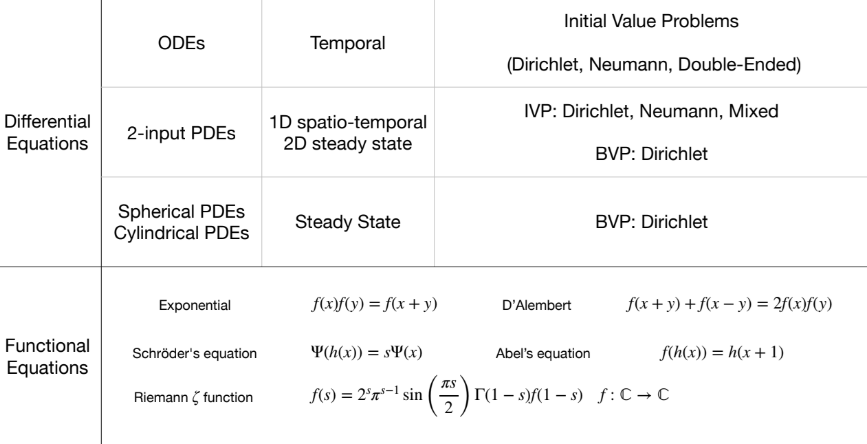

**Source: https://github.com/NeuroDiffGym/neurodiffeq?tab=readme-ov-file**

## The Diff Function

This is at the core of NeuroDiffEq. We use this to write the differential equations that we pass to the solver. 

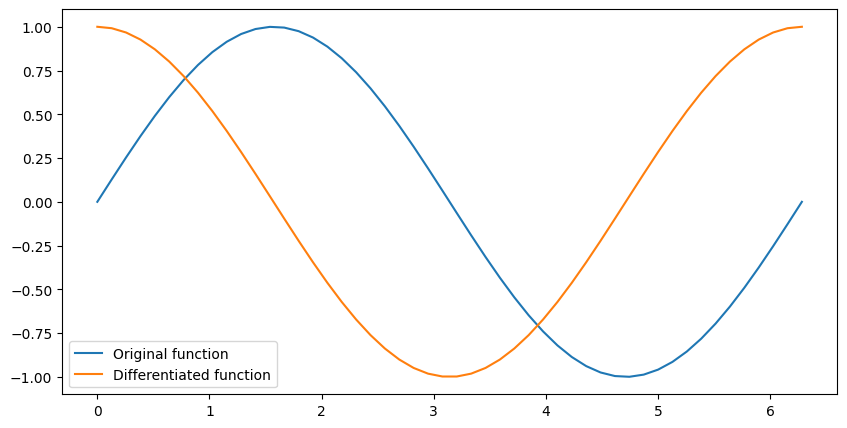

In [8]:
t = torch.linspace(0,2*torch.pi,50,requires_grad=True)
t = torch.reshape(t,(-1,1)) #The -1 reduces the dimension to a single dimension. This turns the input into a single column vector
u = torch.sin(t)
du_dt = neurodiffeq.diff(u,t)

plt.figure(figsize=(10,5))
plt.plot(t.detach().numpy(),u.detach().numpy(),label="Original function")
plt.plot(t.detach().numpy(),du_dt.detach().numpy(),label= "Differentiated function")
plt.legend()

## Solving the 1-D Heat Equation

The 1-D Heat Equation:
$$\frac{\partial u}{\partial t} - k \frac{\partial^2 u}{\partial x^2} = 0$$
Consider the following initial condition and 2 Neumann boundary conditions:
$$u(x,t) \rvert_{t=0} = sin(\pi x)$$
$$\frac{\partial u (x, t)}{\partial x} \rvert_{x=0} = \pi exp(-k \pi^2 t)$$
$$\frac{\partial u (x, t)}{\partial x} \rvert_{x=0} = - \pi exp(-k \pi^2 t)$$
The analytical solution:
$$u(x,t) = sin(\pi \frac{x}{L})exp(\frac{-k \pi^2 t}{L^2})$$
Given that the function is in x and t, we will use solve2D; we will also use IPVP1D condition in order to enforce the initial boundary condition. 

In [9]:
# Define the PDE system
# There's only one (Laplace) equation in the system, so the function maps (u, x, y) to a single entry
laplace = lambda u, x, y: [
    diff(u, x, order=2) + diff(u, y, order=2)
]

# Define the boundary conditions
# There's only one function to be solved for, so we only have a single condition
conditions = [
    DirichletBVP2D(
        x_min=0, x_min_val=lambda y: torch.sin(np.pi*y),
        x_max=1, x_max_val=lambda y: 0,
        y_min=0, y_min_val=lambda x: 0,
        y_max=1, y_max_val=lambda x: 0,
    )
]

# Define the neural network to be used
# Again, there's only one function to be solved for, so we only have a single network
nets = [
    FCNN(n_input_units=2, n_output_units=1, hidden_units=[512])
]

# Define the monitor callback
monitor=Monitor2D(check_every=20, xy_min=(0, 0), xy_max=(1, 1))
monitor_callback = monitor.to_callback()

# Instantiate the solver
solver = Solver2D(
    pde_system=laplace,
    conditions=conditions,
    xy_min=(0, 0),  # We can omit xy_min when both train_generator and valid_generator are specified
    xy_max=(1, 1),  # We can omit xy_max when both train_generator and valid_generator are specified
    nets=nets,
    train_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced-noisy'),
    valid_generator=Generator2D((32, 32), (0, 0), (1, 1), method='equally-spaced'),
)

# Fit the neural network
solver.fit(max_epochs=200, callbacks=[])

# Obtain the solution
solution_neural_net_laplace = solver.get_solution()

Training Progress: 100%|██████████| 200/200 [00:31<00:00,  6.26it/s]


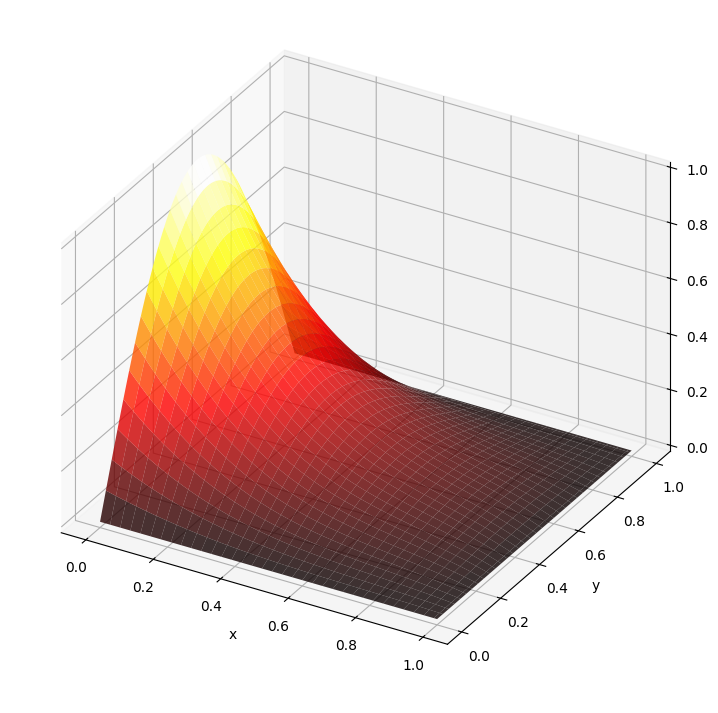

In [21]:
def plt_surf(xx, yy, zz, z_label='u', x_label='x', y_label='y', title=''):
    fig  = plt.figure(figsize=(16, 9))
    ax   = plt.axes(projection ='3d')
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_proj_type('ortho')
    ax.plot_surface(xx, yy, zz, cmap='hot',alpha=0.8,)    
    plt.show()

xs, ys = np.linspace(0, 1, 101), np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)

sol_net = solution_neural_net_laplace(xx, yy, to_numpy=True)

plt_surf(xx, yy, sol_net, title='$u(x, y)$ as solved by neural network')


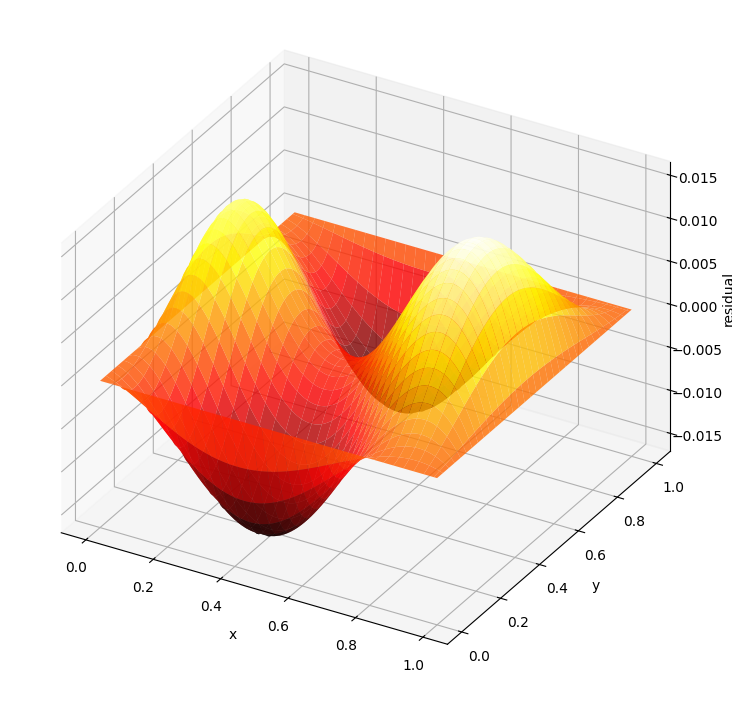

In [22]:
solution_analytical_laplace = lambda x, y: np.sin(np.pi*y) * np.sinh(np.pi*(1-x))/np.sinh(np.pi)
sol_ana = solution_analytical_laplace(xx, yy)
plt_surf(xx, yy, sol_net-sol_ana, z_label='residual', title='residual of the neural network solution')

# Learning the potential function of a simple harmonic oscillator

## Train for the potential function

The problem consists on solving the differential equation using `neurodiffeq` and recover the potential $V$ that we pretend to not know. We denote $x$ as the time and $y$ as the displacement to make it easier to work with the variables. $m$ is the mass of the oscillator and $k$ is the spring constant.

$$w = \sqrt \frac{k}{m}$$

$$m\ddot y + ky = 0 $$

To simplify the process we will take $m=1$

$$ \frac{d^2y}{dx^2} + \frac{dV}{dy} = 0 $$



When the potential, $V$, is unknown. The case at hand is the harmonic oscilator for which $dV/dy = ky$, where $w=2$, $k=4$, $\;\boxed{\Rightarrow V(y) = (k/2)y^2 = 2y^2}$. For this diff eq and this potential, the solution is $\boxed{y(x) = \sin(wx)}$

To deal with ODE systems, we **split it into a system of ODEs**:

$$ \frac{d(vy)}{dx} + \frac{dV}{dy} = 0 $$

$$ vy - \frac{dy}{dx} = 0 $$

**We define NNs for both systems** that take $x$ and output $y(x)$ (`net_xy`) and $x$ to output $dy/dx$ (`net_xvy`) respectively. They also define an auxiliary NN that takes $y$ and outputs $V(y)$ (`net_yV`). `net_xy` and `net_xvy` are the NNs of the solver, but `net_xvy` is internal to the system and has to be accessed via callbacks. **The interesting thing about this is that the NN is being trained on data from x and y, and manages to optimize well for V(y) as well**.

**Callback:** a feature to inject custom code into the training loop of a NN to perform various actions at different stages of the training process without modifying the core training loop.

First we define the data we want to train on 

In [5]:
## Generate data
w = 2.0
k = 4.0 

x_true = np.linspace(0, np.pi, 256)
# True data is y = sin(wx) + noise
y_true =  np.sin(w*x_true) + 0.2*np.random.randn(256)

train_gen = Generator1D(size=128,  t_min=0.0, t_max=np.pi, method='equally-spaced-noisy')
valid_gen = Generator1D(size=128, t_min=0.0, t_max=np.pi, method='equally-spaced')

The generator objects are called during training to generate data at the sampled points. We can see this using their .get_examples() method.This makes the process of generating data for ODEs much easier. There are various different types of generators in NeuroDiffEq like 1D, 2D, 3D etc.

In [6]:
train_gen.get_examples()

tensor([0.0047, 0.0205, 0.0423, 0.0737, 0.1060, 0.1212, 0.1424, 0.1719, 0.1918,
        0.2177, 0.2422, 0.2802, 0.2874, 0.3219, 0.3461, 0.3631, 0.3915, 0.4219,
        0.4395, 0.4739, 0.4961, 0.5155, 0.5437, 0.5668, 0.5851, 0.6266, 0.6401,
        0.6640, 0.6930, 0.7110, 0.7441, 0.7655, 0.7893, 0.8158, 0.8477, 0.8648,
        0.8857, 0.9164, 0.9292, 0.9629, 0.9889, 1.0120, 1.0463, 1.0618, 1.0946,
        1.1176, 1.1399, 1.1654, 1.1867, 1.2105, 1.2437, 1.2667, 1.2913, 1.3059,
        1.3433, 1.3565, 1.3833, 1.4045, 1.4265, 1.4624, 1.4823, 1.5051, 1.5408,
        1.5525, 1.5857, 1.5993, 1.6219, 1.6591, 1.6940, 1.7046, 1.7313, 1.7676,
        1.7857, 1.7983, 1.8353, 1.8584, 1.8743, 1.9152, 1.9234, 1.9502, 1.9683,
        1.9985, 2.0284, 2.0563, 2.0776, 2.0984, 2.1312, 2.1623, 2.1747, 2.1989,
        2.2221, 2.2552, 2.2751, 2.3000, 2.3285, 2.3404, 2.3748, 2.3873, 2.4272,
        2.4457, 2.4686, 2.4905, 2.5286, 2.5501, 2.5728, 2.5969, 2.6238, 2.6481,
        2.6703, 2.6874, 2.7212, 2.7388, 

Next we define our network and system of equations

In [7]:
## x --> y --> V
# Specify the network architecture
# Each Fully Connected Neural Netwrok (FCNN) has 1 input layer, 2 hidden layers (each with 64 units), and 1 output layer
net_xy = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # this one takes x and outputs y(x)

net_xvy = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # this takes x and outputs vy=dy/dx

net_yV = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
) # This one takes y and outputs V(y)


nets = [net_xy, net_xvy] # this will be the diff eq in NN terms

def system(y, vy, x):
  # We want to solve y'' + dV/dy = 0 but we frame it as a system of first order equations
  V = net_yV(y)
  eq1 = diff(V,y) + diff(vy,x,order = 1)
  eq2 = diff(y,x) - vy
  return [eq1, eq2]


conditions = [
    IVP(t_0=0.0, u_0=0.0),
    IVP(t_0=0.0, u_0=w),
]

Now we define the Solver. This is similar to Solvers from sklearn and keras. We instantiate the solver by specifying the ODE/PDE system, initial/boundary conditions, problem domain, etc.

In [8]:
#Define Solver

class Solver_withMSE(Solver1D):
  def __init__(self, x_true = None, y_true = None, alpha_init = 1, **kwargs):
    super().__init__(**kwargs) # inherit Solver1D __init__
    self.x_true = torch.tensor(x_true, requires_grad = True).view(-1,1) #Same as the reshape shown earlier
    self.y_true = torch.tensor(y_true).view(-1,1)
    self.alpha_init = alpha_init
    self.b = -4

  # overwrite the `additional_loss` method from Solver1D to consider the mse as a term in the loss function
  def additional_loss(self, residual, funcs, coords):
    epochs = self.global_epoch
    max_epochs = self._max_local_epoch
    frac = epochs/max_epochs
    # alpha does annealing of the coefficient of mse loss becase we want the coefficient of the MSE loss to be higher when we start training
    # annealing: Allowing for the trainability to vary with the epoch No. From high variability to low.
    alpha = (self.alpha_init-1)*np.exp(self.b*frac) - (self.alpha_init-1)*np.exp(self.b)*frac + 1
    batch = [self.x_true]

    funcs = [
    self.compute_func_val(n, c, *batch) for n, c in zip(self.nets, self.conditions)
    ] # Computes the function value (the neural net outputs in this case) evaluated 
      # on the points specified by coordinates (the batch/ x_true in this case)

    loss_mse = ((funcs[0]-self.y_true)**2).mean() # simple mean squared error loss. `funcs[0]` is the y prediction. 
                                                  #`funcs[1]` would be the dy/dx prediction.
    return alpha*loss_mse
  
  # We start by emphasizing MSE at first with the high alpha to allow the network to quickly learn the true solution.
  # Alpha is lowered overtime so that MSE is deemphasized, allowing the network to focus more on satisfying the ODE.


#Allows us to use multiple optimizers
class DualOptimizer():
  def __init__(self, optimizers):
    self.optimizers = optimizers

  def step(self, closure = None):
    for opt in self.optimizers:
      opt.step(closure)

  def zero_grad(self):
    for opt in self.optimizers:
      opt.zero_grad()


opt_yx = torch.optim.Adam(set([p for net in nets for p in net.parameters()]), lr=1e-3, weight_decay=0.0001)
opt_potential = torch.optim.Adam(net_yV.parameters(), lr=1e-3)

dualoptimizer = DualOptimizer([opt_yx, opt_potential])

class DoSchedulerStep(ActionCallback):
    def __init__(self, scheduler):
        super().__init__()
        self.scheduler = scheduler

    def __call__(self, solver):
        self.scheduler.step()

class BestValidationCallback(ActionCallback):
    def __init__(self):
        super().__init__()
        self.best_potential = None

    def __call__(self, solver):
        if solver.metrics_history['train_loss'][-1] <= solver.lowest_loss:
            self.best_potential = copy.deepcopy(net_yV)  #Saves the best model of the potential


#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=1200, gamma=0.95) #This changes the learning rate during the training process
#scheduler_cb = DoSchedulerStep(scheduler=scheduler)
potential_cb = BestValidationCallback()


solver = Solver_withMSE(
    x_true = x_true,
    y_true = y_true,
    alpha_init = 10,
    ode_system=system,
    conditions=conditions,
    t_min=0,
    t_max=np.pi,
    optimizer = dualoptimizer,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets,
    n_batches_valid=0,
)


In [9]:
#Fitting the solver

solver.fit(max_epochs=15000, callbacks=[potential_cb])#, scheduler_cb])


Training Progress: 100%|██████████| 15000/15000 [07:41<00:00, 32.51it/s]


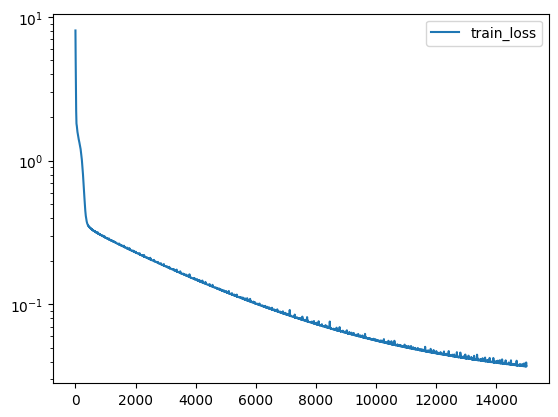

In [10]:
#Plotting loss of the training and validation datasets  q
history = solver.metrics_history

plt.plot(history['train_loss'], label = 'train_loss')
#plt.plot(history['valid_loss'], label = 'valid_loss')
plt.legend()
plt.yscale('log')

C:\Users\nachi\AppData\Local\Temp\ipykernel_28652\4116335924.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mse1 = ((ys.cpu().detach()-y_true)**2).mean()


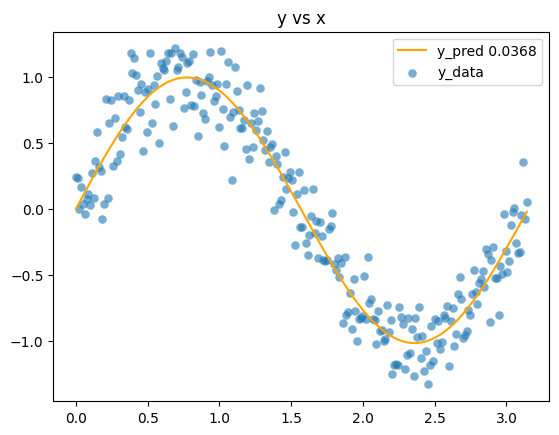

In [ ]:
solution = solver.get_solution(best=True)
xs = np.linspace(0, np.pi, 256)
ys = solution(xs)[0] # solution evaluated at points xs. The [0] is because the tensor is returned in a list i.e [tensor]
mse1 = ((ys.cpu().detach()-y_true)**2).mean()

#Since ys is a tensor as it is the output of the NN, we need .cpu().detach().numpy() to turn it into an object we can pass to the ploot func

plt.plot(xs, ys.cpu().detach().numpy(), label = 'y_pred {:.4f}'.format(mse1), color = 'orange')
plt.scatter(x_true, y_true, label = 'y_data', lw = 0.1, alpha = 0.6)
plt.legend()
plt.title('y vs x')
plt.show()

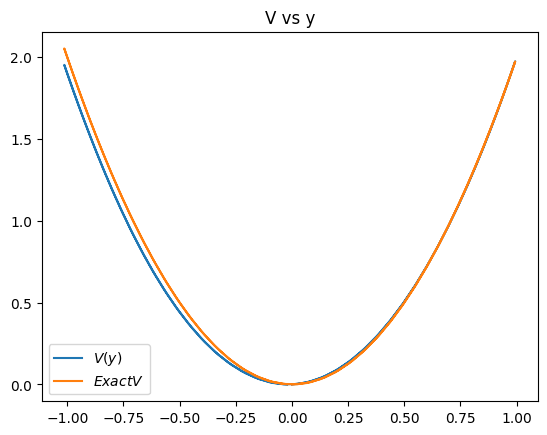

In [12]:
solution = solver.get_solution(best=True)
xs = torch.tensor(np.linspace(0, np.pi, 100)).view(-1,1)
ys = solution(xs)[0].view(-1,1)
Vs = potential_cb.best_potential(ys)
dVdy = diff(Vs, ys)
plt.plot(ys.cpu().detach().numpy(), Vs.cpu().detach().numpy() - Vs[0].item(), label = '$V(y)$')
#Exact potential = 1/2*k*y^2
plt.plot(ys.cpu().detach().numpy(), 0.5*(k)*ys.pow(2).cpu().detach().numpy(), label = '$Exact V$')
plt.legend()
plt.title('V vs y')
plt.show()

Next we use PySR, a package that performs symbolic regression. It is a ML package that tries to find the underlying equation that governs the data. We are trying to recover the functional form of the V potential predicted by the PINN. More about PySR here: https://github.com/MilesCranmer/PySR

In [13]:
solution = solver.get_solution(best=True)
xs = torch.tensor(np.linspace(0, np.pi, 100)).view(-1,1)
ys = solution(xs)[0].view(-1,1)
Vs = potential_cb.best_potential(ys)


X = ys.cpu().detach().numpy() #The displacement that the PINN predicted
y = Vs.cpu().detach().numpy() - Vs[0].item() #The potential that the PINN optimized

from pysr import PySRRegressor

model_SR = PySRRegressor(
    niterations=50,  # < Increase me for better results
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)
model_SR.set_params(extra_torch_mappings = {'inv(x)': lambda x: 1/x})

c:\Users\nachi\OneDrive\Desktop\cphysics\c_physics_projects\.pysrenv\Lib\site-packages\pysr\sr.py:986: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(


PySRRegressor.equations_ = None

In [14]:
model_SR.fit(X, y) #Fitting a functional form to the data. Done through a tournament style picking of different symbolic expressions.

c:\Users\nachi\OneDrive\Desktop\cphysics\c_physics_projects\.pysrenv\Lib\site-packages\pysr\sr.py:2727: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.180e+05
Progress: 776 / 1550 total iterations (50.065%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.878e-01  1.594e+01  y = 0.96509
3           3.245e-01  2.038e-01  y = inv(cos(x₀))
4           2.882e-01  1.187e-01  y = sin(exp(cos(x₀)))
5           1.477e-03  5.274e+00  y = (x₀ * x₀) * 1.9384
7           8.083e-05  1.453e+00  y = ((x₀ + 0.027267) * x₀) * 1.9404
9           5.458e-05  1.963e-01  y = (x₀ * ((x₀ * 1.952) + 0.053078)) + -0.0087931
11          5.458e-05  7.451e-07  y = ((x₀ * 0.89327) * ((x₀ * 2.1853) + 0.059419)) + -0.008...
                                      806
13          3.759e-05  1.865e-01  y = (((x₀ * cos(cos(x₀) + -0.58696)) + 0.0272) * 1.9476) *...
                                       x₀
14          9.449e-06  

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.96509063   
	1         0.203788                                       inv(cos(x0))   
	2         0.118747                                  sin(exp(cos(x0)))   
	3         5.273733                               (x0 * x0) * 1.938442   
	4         1.452635              ((x0 + 0.027266823) * x0) * 1.9403778   
	5         0.196308  (((x0 * 1.9520171) + 0.05307775) * x0) + -0.00...   
	6         0.000001  ((x0 * 1.6413094) * ((x0 * 1.1893045) + 0.0323...   
	7         0.186518  (((x0 * cos(cos(x0) + -0.5869588)) + 0.0272004...   
	8         1.380695  (((x0 + (x0 + (sin(x0) * -0.40102172))) * 1.17...   
	9         1.799054  ((x0 + x0) + (sin(sin(x0) + -0.22933587) * -0....   
	10        0.443364  ((((x0 + 0.025857855) + x0) + (sin(x0 + -0.079...   
	11        0.099164  x0 * (((x0 + sin((sin(x0 + -0.072755784) + -0....   
	12  >>>>  0.181350  ((x0 * 1.2646022) + 0.024861014) * (x0 + (((x0...   
	
	            loss  complexity  
	0   4.877832e-01           1  
	1   3.245032e-01           3  
	2   2.881694e-01           4  
	3   1.476709e-03           5  
	4   8.082626e-05           7  
	5   5.458105e-05           9  
	6   5.458093e-05          11  
	7   3.758666e-05          13  
	8   9.449427e-06          14  
	9   1.563458e-06          15  
	10  1.003542e-06          16  
	11  9.088016e-07          17  
	12  6.323400e-07          19  
]

  - outputs\20241203_004246_mKo4MH\hall_of_fame.csv


## Train PINN on candidate potentials without data then validate with data

Now that we have a list of candidates for the functional form of the potential, we will train the PINN on each of these candidates without showing it the true data. This way we force the network to adhere to the physical constraints and satisfy the diff. eq. at every point in the domain.

Training Progress: 100%|██████████| 2000/2000 [00:29<00:00, 68.56it/s]


Candidate potential : 0.965090630000000 MSE with data : 15.7762554


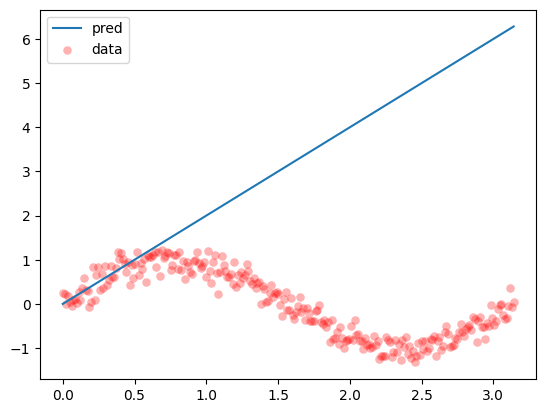

Training Progress: 100%|██████████| 2000/2000 [00:25<00:00, 78.39it/s]


Candidate potential : 1/cos(x0) MSE with data : 16.3141728


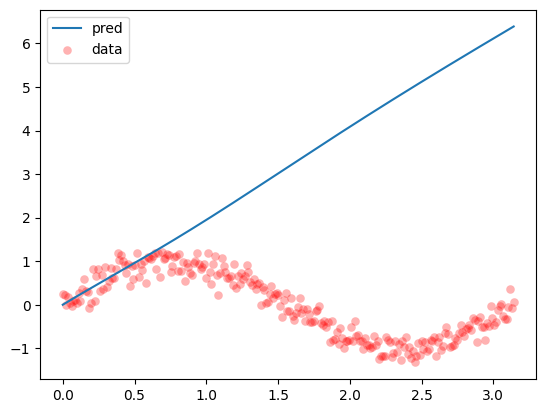

Training Progress: 100%|██████████| 2000/2000 [00:24<00:00, 81.78it/s]


Candidate potential : sin(exp(cos(x0))) MSE with data : 14.0291569


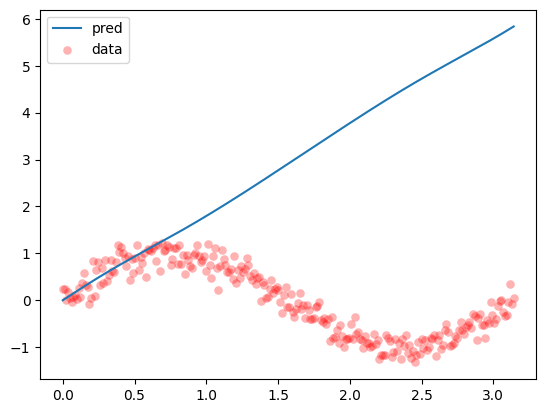

Training Progress: 100%|██████████| 2000/2000 [00:25<00:00, 78.61it/s]


Candidate potential : x0*x0*1.938442 MSE with data : 0.0386145


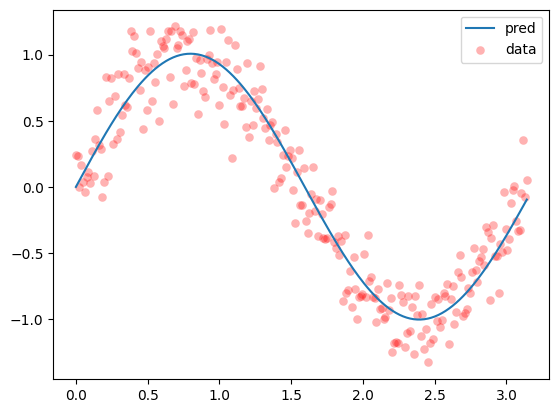

Training Progress: 100%|██████████| 2000/2000 [00:28<00:00, 71.05it/s]


Candidate potential : (x0 + 0.027266823)*x0*1.9403778 MSE with data : 0.0380222


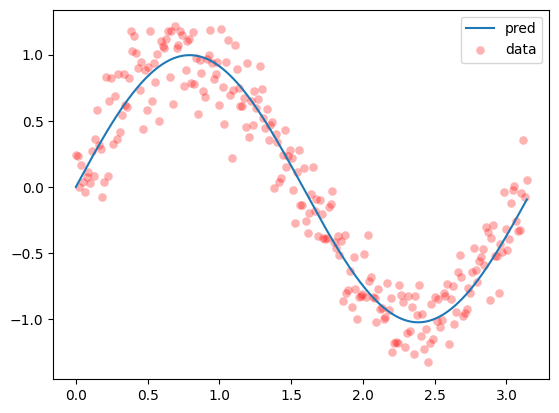

Training Progress: 100%|██████████| 2000/2000 [00:25<00:00, 78.58it/s]


Candidate potential : x0*(x0*1.9520171 + 0.05307775) - 0.008793162 MSE with data : 0.0397103


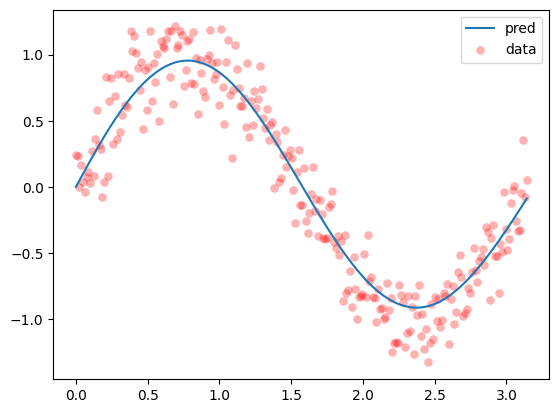

Training Progress: 100%|██████████| 2000/2000 [00:24<00:00, 80.39it/s]


Candidate potential : x0*1.6413094*(x0*1.1893045 + 0.032338914) - 0.008792923 MSE with data : 0.0378069


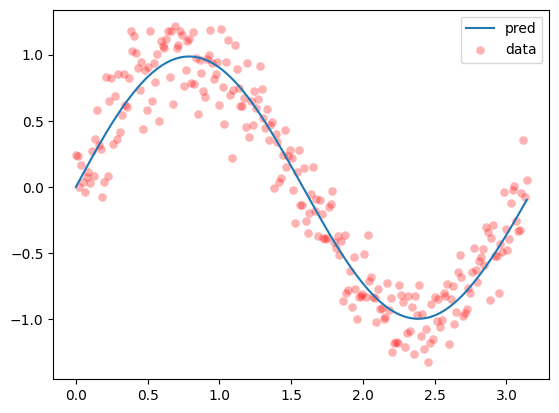

LOWEST MSE OBTAINED BY:  x0*1.6413094*(x0*1.1893045 + 0.032338914) - 0.008792923  =  0.03780692371028645


In [ ]:
top7_candidates = model_SR.pytorch(index = list(range(7))) # This retrieves a torch-like symbolic expression that can be used to evaluate tensors
min_loss = 1e5 # this is just initializing the min_loss to a large value. You could do np.inf
min_loss_cand = None
trained_cand_nets = [] # We store copies of the NN that have been trained on the candidate potentials to fine tune later
for cand in top7_candidates:
  net_xy_cand = FCNN(
    hidden_units=(64, 64,), actv=nn.Tanh
  )

  def system_cand(y, x):
    V = cand(y).view(-1,1) # calculating the potential given by symbolic expression (that is trainable??)
    if V.shape == torch.Size([1, 1]):
      V = V * torch.ones_like(y)
    eq1 = diff(V,y) + diff(y,x,order = 2) # this is the whole DE of 2nd order
    return [eq1]

  nets_cand = [net_xy_cand]
  opt_yx_cand = torch.optim.Adam(set([p for net in nets_cand for p in net.parameters()]), lr=1e-3)
  conditions_cand = [
    IVP(t_0=0.0, u_0=0.0, u_0_prime = w),
  ]

  solver_cand = Solver1D(
    ode_system=system_cand,
    conditions=conditions_cand,
    t_min=0,
    t_max=np.pi,
    optimizer = opt_yx_cand,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets_cand,
    n_batches_valid=0,
  )

  solver_cand.fit(max_epochs = 2000)
  solution_cand = solver_cand.get_solution(best = True)
  y_pred = solution_cand(x_true).cpu().detach().numpy()
  mse = ((y_pred - y_true)**2).mean()
  if mse < min_loss:
    min_loss = mse
    min_loss_cand = cand
  print('Candidate potential :',cand._expression_string, 'MSE with data : {:.7f}'.format(mse))
  plt.plot(x_true, y_pred, label = 'pred')
  plt.scatter(x_true, y_true, label = 'data', color = 'red', alpha = 0.3, lw = 0.1)
  plt.legend()
  plt.show()
  print('================================================')
  trained_cand_nets.append(copy.deepcopy(net_xy_cand)) 

print('LOWEST MSE OBTAINED BY: ',min_loss_cand._expression_string, ' = ', min_loss)
print('================================================')

Although we see that the lowest MSE is obtained by an expression that is not representative of the real potential function, the true expression for V performs quite well.

## Finetuning candidates on the trained net
We now pass the true data to the solver to let it fine tune each of the candidate NNs

Training Progress: 100%|██████████| 2000/2000 [00:32<00:00, 61.66it/s]


parameters after training:  [('_node._value', Parameter containing:
tensor(0.9651, requires_grad=True))]
Candidate potential : 0.965090630000000 MSE : 0.4584494 Lowest Loss : 2.0143563


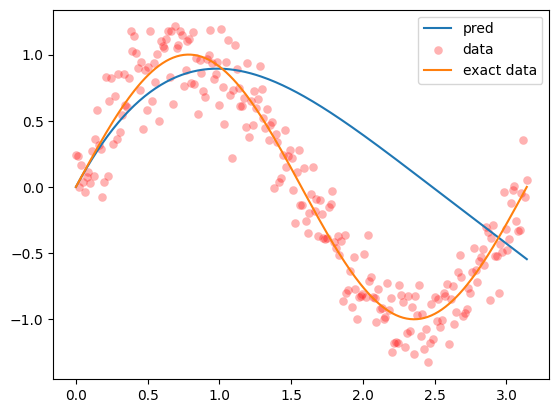

Training Progress: 100%|██████████| 2000/2000 [00:31<00:00, 63.35it/s]


parameters after training:  []
Candidate potential : 1/cos(x0) MSE : 15.1194198 Lowest Loss : 12336.9825945


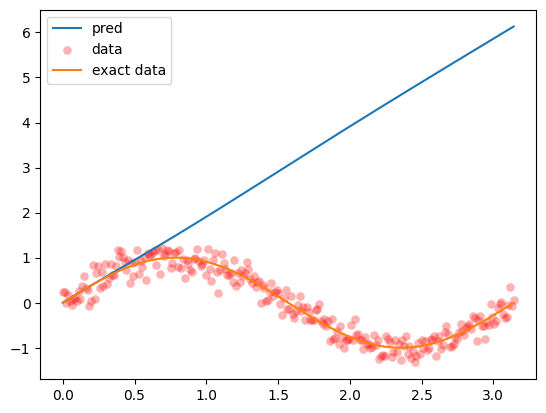

Training Progress: 100%|██████████| 2000/2000 [00:32<00:00, 61.97it/s]


parameters after training:  []
Candidate potential : sin(exp(cos(x0))) MSE : 0.2695368 Lowest Loss : 1.0688227


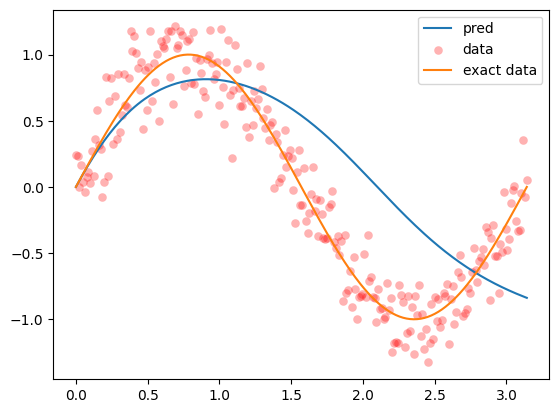

Training Progress: 100%|██████████| 2000/2000 [00:31<00:00, 62.70it/s]


parameters after training:  [('_node._args.2._value', Parameter containing:
tensor(1.9978, requires_grad=True))]
Candidate potential : x0*x0*1.938442 MSE : 0.0370442 Lowest Loss : 0.0371171


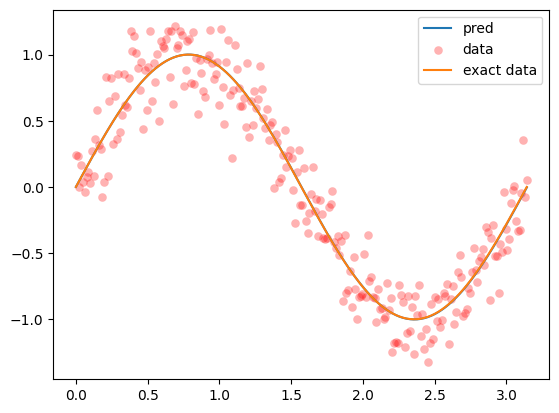

Training Progress: 100%|██████████| 2000/2000 [00:31<00:00, 64.00it/s]


parameters after training:  [('_node._args.0._args.1._value', Parameter containing:
tensor(0.0187, requires_grad=True)), ('_node._args.2._value', Parameter containing:
tensor(1.9891, requires_grad=True))]
Candidate potential : (x0 + 0.027266823)*x0*1.9403778 MSE : 0.0369584 Lowest Loss : 0.0370723


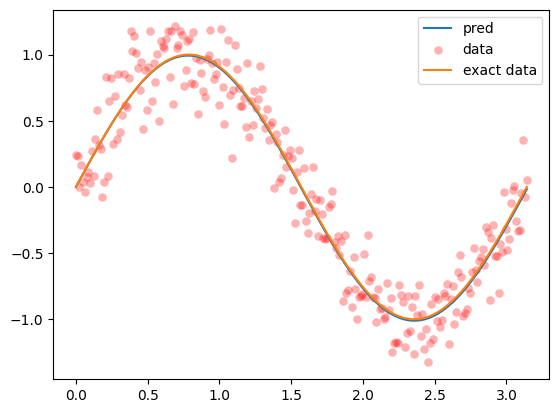

Training Progress: 100%|██████████| 2000/2000 [00:31<00:00, 63.64it/s]


parameters after training:  [('_node._args.0._args.0._args.0._args.1._value', Parameter containing:
tensor(1.9892, requires_grad=True)), ('_node._args.0._args.0._args.1._value', Parameter containing:
tensor(0.0368, requires_grad=True)), ('_node._args.1._value', Parameter containing:
tensor(-0.0088, requires_grad=True))]
Candidate potential : x0*(x0*1.9520171 + 0.05307775) - 0.008793162 MSE : 0.0369613 Lowest Loss : 0.0370757


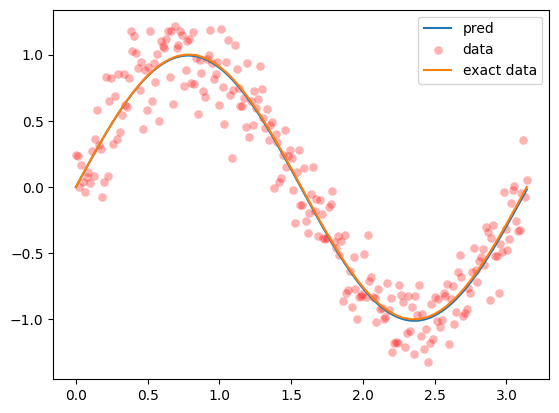

Training Progress: 100%|██████████| 2000/2000 [00:31<00:00, 62.86it/s]


parameters after training:  [('_node._args.0._args.1._value', Parameter containing:
tensor(1.6514, requires_grad=True)), ('_node._args.0._args.2._args.0._args.1._value', Parameter containing:
tensor(1.2039, requires_grad=True)), ('_node._args.0._args.2._args.1._value', Parameter containing:
tensor(0.0231, requires_grad=True)), ('_node._args.1._value', Parameter containing:
tensor(-0.0088, requires_grad=True))]
Candidate potential : x0*1.6413094*(x0*1.1893045 + 0.032338914) - 0.008792923 MSE : 0.0369607 Lowest Loss : 0.0371148


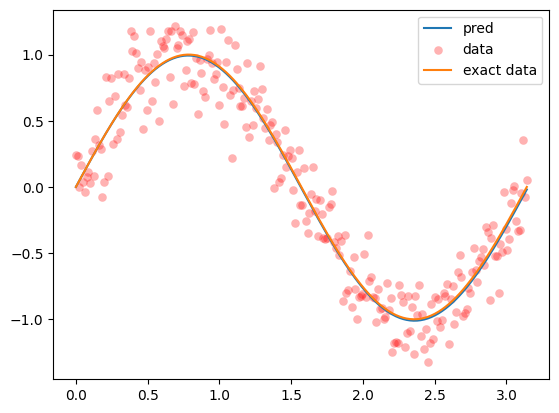

LOWEST MSE OBTAINED BY:  (x0 + 0.027266823)*x0*1.9403778  =  0.03695837017512475


In [ ]:
top7_candidates = model_SR.pytorch(index = list(range(7)))
min_loss_cand = None
min_loss = 1e5

for i,cand in enumerate(top7_candidates):

  def system_cand(y, x):
    V = cand(y).view(-1,1)
    if V.shape == torch.Size([1, 1]):
      V = V * torch.ones_like(y)
    eq1 = diff(V,y) + diff(y,x,order = 2)
    return [eq1]
    
  nets_cand = [trained_cand_nets[i]] 
  opt_yx_cand = torch.optim.Adam(set([p for net in nets_cand for p in net.parameters()]), lr=1e-3, weight_decay = 0.0001)
  conditions_cand = [
    IVP(t_0=0.0, u_0=0.0, u_0_prime = 2.0),
  ]
  if len(list(cand.parameters()))>0:
    opt_cand = torch.optim.Adam(cand.parameters(), lr=1e-2)
    dualoptimizer_cand = DualOptimizer([opt_yx_cand, opt_cand])
    opt_final = dualoptimizer_cand
  else:
    opt_final = opt_yx_cand

  # Notice that is is now the solver with MSE we defined at the start and we pass the true data for fine tuning
  solver_cand = Solver_withMSE(
    x_true = x_true,
    y_true = y_true,
    ode_system=system_cand,
    conditions=conditions_cand,
    t_min=0,
    t_max=np.pi,
    optimizer = opt_final,
    train_generator=train_gen,
    valid_generator=valid_gen,
    nets=nets_cand,
    n_batches_valid=0,
  )
  solver_cand.fit(max_epochs = 2000)
  print('parameters after training: ',list(cand.named_parameters()))
  solution_cand = solver_cand.get_solution(best = True)
  y_pred = solution_cand(x_true).cpu().detach().numpy()
  mse = ((y_pred - y_true)**2).mean()
  if mse < min_loss:
    min_loss = mse
    min_loss_cand = cand
    
  print('Candidate potential :',cand._expression_string, 'MSE : {:.7f}'.format(((y_pred - y_true)**2).mean()), 'Lowest Loss : {:.7f}'.format(solver_cand.lowest_loss))#, solver_cand.lowest_loss)
  plt.plot(x_true, y_pred, label = 'pred')
  plt.scatter(x_true, y_true, label = 'data', color = 'red', alpha = 0.3, lw = 0.1)
  plt.plot(x_true, np.sin(2*x_true), label = 'exact data')
  plt.legend()
  plt.show()
  print('================================================')
print('LOWEST MSE OBTAINED BY: ',min_loss_cand._expression_string, ' = ', min_loss)
print('================================================')

While it may not be the lowest MSE, the true potential fits the data very well. The PINN has learned the potential of the function implicitely while fitting for the displacement. This is just a basic overview and we can take this concept much further. You can try adding a mass and rewriting the differential equation. You can also try adding a phase shift to the true data. This can be applied to many differnt ODEs that descrbe physical systems. Hyperparameters unfortunately play a key role here but they can be finetuned using libraries like RayTune to adjust things like the size of the hidden units and the number of layers in the NNs to achieve better results.